In [12]:
import polars as pl
import os
from pathlib import Path
from polars.exceptions import ColumnNotFoundError

# Robustly locate the data file by searching the current working directory, parents, repo folders on common drives, and as a last resort drive-wide search
data_filename = 'sampledata_truthsocial.csv'
repo_name = 'cib-mango-tree-peter'

def find_data_file(data_filename, max_parent_levels=10):
    cwd = Path.cwd()
    tried = []
    # 1) Check cwd and its parents for data/<filename>
    for p in [cwd] + list(cwd.parents)[:max_parent_levels]:
        candidate = p / 'data' / data_filename
        tried.append(str(candidate))
        if candidate.exists():
            print(f"Found data file at {candidate} (from cwd parents)")
            return str(candidate)

    # 2) Look for repo_name in common drive roots (fast) and search under it
    for drive_letter in ['D:', 'C:', 'E:']:
        drive_root = Path(drive_letter + os.sep)
        if drive_root.exists():
            candidate_repo = drive_root / 'GitHub' / repo_name
            tried.append(str(candidate_repo))
            if candidate_repo.exists():
                try:
                    matches = list(candidate_repo.rglob(data_filename))
                    if matches:
                        print(f"Found data file under repo path {candidate_repo}")
                        return str(matches[0])
                except Exception:
                    pass

    # 3) Try to detect repo root by scanning cwd parents for .git/src/reports and then rglob under it
    for p in [cwd] + list(cwd.parents)[:max_parent_levels]:
        if (p / '.git').exists() or (p / 'src').exists() or (p / 'reports').exists():
            repo_root = p
            tried.append(str(repo_root))
            try:
                matches = list(repo_root.rglob(data_filename))
                if matches:
                    print(f"Found data file under detected repo root {repo_root}")
                    return str(matches[0])
            except Exception:
                pass

    # 4) As a last resort, attempt a drive-wide search on the current drive (may be slow; wrap in try/except)
    try:
        drive_root = Path(cwd.anchor)
        tried.append(str(drive_root))
        matches = list(drive_root.rglob(data_filename))
        if matches:
            print(f"Found data file via drive-wide search under {drive_root}")
            return str(matches[0])
    except Exception as e:
        # Don't raise; we'll show tried locations below
        print(f"Drive-wide search failed: {e}")

    print("Tried paths (first 20 shown):")
    for t in tried[:20]:
        print(" - ", t)
    return None

found_path = find_data_file(data_filename)
if found_path:
    data_file_path = found_path
else:
    # Last resort: keep original relative path (will raise meaningful FileNotFoundError)
    data_file_path = os.path.join('..', 'data', data_filename)
    print(f"Using fallback data path: {data_file_path}")

try:
    # Load the CSV file using polars
    df = pl.read_csv(data_file_path)

    # Display the first few rows to verify loading
    print("Data loaded successfully. First 5 rows:")
    print(df.head())

    # Display the data types of the columns
    print("\nData Types:")
    print(df.dtypes)

except FileNotFoundError:
    print(f"Error: Data file not found at {data_file_path}")
    print("Please ensure the filename is correct and the file exists in the 'data/' directory.")
except OSError as e:
    print(f"An OS error occurred while accessing the data file: {e}")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Found data file at D:\GitHub\cib-mango-tree-peter\data\sampledata_truthsocial.csv (from cwd parents)
Data loaded successfully. First 5 rows:
shape: (5, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ account.d ┆ account.u ┆ account.i ┆ content_c ┆ … ┆ in_reply_ ┆ reblog.id ┆ replies_c ┆ reblogs_ │
│ isplay_na ┆ sername   ┆ d         ┆ leaned    ┆   ┆ to_id     ┆ ---       ┆ ount      ┆ count    │
│ me        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ ---       ┆ str       ┆ i64       ┆ str       ┆   ┆ f64       ┆           ┆ i64       ┆ i64      │
│ str       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ suzyQpatr ┆ suzyQpatr ┆ 107842819 ┆ RT @corte ┆ … ┆ null      ┆ 1.1390e17 ┆ 0         ┆ 0        │
│ iot       ┆ iot       ┆ 492508562 

## Step: Isolate and Prepare Post Timestamp (created_at) Column
**Why are we doing this?**

Focus: Our goal is time series analysis, specifically looking for patterns in when posts occur. The created_at column contains this crucial time information. Isolating it removes irrelevant data (like post content, usernames, etc.) for this specific analysis, making the process cleaner and more efficient. We rename it to post_timestamp simply for clarity and consistency with your proposal.




Correct Data Type: Computers need to understand that the values in this column represent points in time, not just sequences of characters (strings) or numbers. Time series analysis functions (like plotting over time, calculating autocorrelations, or aggregating by hour/day) require the data to be in a specific datetime format. If the data is currently a string (e.g., "2023-10-27 10:30:00") or a number (e.g., a Unix timestamp like 1698399000), we must convert it so the software can perform time-based calculations correctly.

**How does this affect the next step?**

Enables Time-Based Operations: Once the post_timestamp column is in the correct datetime format, we can perform essential time series operations. The very next step in your Week 1 plan is Initial Time-Series Diagnostics. This involves:


Visualization: Plotting the number of posts over time (e.g., posts per hour or day). This requires the datetime type to correctly order and space the data points on the time axis.


Aggregation: To perform burst detection or plot posts-per-hour, we need to group the data by time intervals (hour, minute, day). This aggregation relies heavily on the datetime data type.


ACF Calculation: Calculating the Autocorrelation Function (ACF) involves comparing the time series with lagged versions of itself. This inherently requires the data to be ordered correctly by time, which the datetime format ensures.




Foundation for Modeling: All subsequent analysis, including Burst Detection and Temporal Clustering (which involves extracting features like hour-of-day ), fundamentally depends on having accurate and usable timestamp data. Getting this step right is crucial for the validity of all future results.

In [13]:
try:
    # Load the CSV file using polars
    df = pl.read_csv(data_file_path)

    # --- Select and Prepare Timestamp ---
    ts_df = df.select(
        pl.col('created_at').alias('post_timestamp')
    )
    print("Original data type of post_timestamp:")
    print(ts_df.dtypes)

    if ts_df['post_timestamp'].dtype == pl.Utf8 or ts_df['post_timestamp'].dtype == pl.String:
        print("\nConverting string (ISO 8601 format) to datetime...")
        try:
            # Try Polars' fast parser first
            ts_df = ts_df.with_columns(
                pl.col('post_timestamp').str.to_datetime().alias('post_timestamp')
            )
            print("Automatic conversion successful!")
        except Exception as e:
            # Fall back to an eager, robust Python parsing approach using dateutil
            print(f"Automatic conversion failed ({e}). Falling back to Python parsing (dateutil)...")
            from dateutil import parser as _parser

            raw_values = ts_df['post_timestamp'].to_list()
            parsed = []
            for s in raw_values:
                if s is None or s == "":
                    parsed.append(None)
                    continue
                try:
                    parsed.append(_parser.isoparse(s))
                except Exception:
                    parsed.append(None)

            ts_df = ts_df.with_columns(
                pl.Series('post_timestamp', parsed).cast(pl.Datetime)
            )

        print("\nConverted data type:")
        print(ts_df.dtypes)
        print("\nNote: Timestamps are now in polars datetime[μs] (naive) which is compatible with subsequent aggregation.")


    # Display the first few rows with the prepared timestamp
    print("\nPrepared Timestamp Data:")
    print(ts_df.head())

except ColumnNotFoundError:
    print("Error: Column 'created_at' not found in the DataFrame.")
except Exception as e:
    print(f"An error occurred during conversion: {e}")

Original data type of post_timestamp:
[String]

Converting string (ISO 8601 format) to datetime...
Automatic conversion failed (`strptime` / `to_datetime` was called with no format and no time zone, but a time zone is part of the data.

This was previously allowed but led to unpredictable and erroneous results. Give a format string, set a time zone or perform the operation eagerly on a Series instead of on an Expr.). Falling back to Python parsing (dateutil)...

Converted data type:
[Datetime(time_unit='us', time_zone=None)]

Note: Timestamps are now in polars datetime[μs] (naive) which is compatible with subsequent aggregation.

Prepared Timestamp Data:
shape: (5, 1)
┌─────────────────────────┐
│ post_timestamp          │
│ ---                     │
│ datetime[μs]            │
╞═════════════════════════╡
│ 2025-01-27 05:04:04.797 │
│ 2025-01-27 05:07:12.056 │
│ 2025-01-27 05:07:16.126 │
│ 2025-01-27 05:07:45.702 │
│ 2025-01-27 05:12:06.137 │
└─────────────────────────┘


**1. Visualization**

**Why do this?** Plotting the data over time is the first step in understanding its behavior. We visually check for:

- Trends: Is the posting activity generally increasing or decreasing over time ?
- Seasonality: Are there repeating patterns within fixed time intervals (e.g., daily, weekly) ?
- Anomalies/Bursts: Are there obvious spikes or unusual periods of activity?
- Variance Stability: Does the amount of fluctuation change depending on the level of activity? (Needed for step 3)

**How does this affect the next step?** Visual inspection gives us initial clues about the data's structure. If we see strong seasonality or trends, it guides how we might approach modeling or transformation later. Obvious bursts might corroborate the findings of our burst detection algorithm.

In [14]:
import plotly.express as px
import polars as pl # Make sure polars is imported

if 'ts_df' not in locals():
    print("Error: ts_df not defined. Run the timestamp-prep cell first to create `ts_df`.")
else:
    try:
        # --- Ensure data is sorted by timestamp ---
        print("Sorting data by post_timestamp...")
        ts_df_sorted = ts_df.sort("post_timestamp")
        print("Sorting complete.")

        # --- Aggregate Data by Hour ---
        # Use the sorted DataFrame (ts_df_sorted) here
        print("Aggregating posts per hour...")
        posts_per_hour = ts_df_sorted.group_by_dynamic(
            index_column="post_timestamp",
            every="1h", # Aggregate into 1-hour bins
        ).agg(
            pl.len().alias('post_count') # Count posts in each bin
        ).sort("post_timestamp")
        print("Aggregation complete.")

        print("\nAggregated posts per hour (first 5 rows):")
        print(posts_per_hour.head())

        # --- Create Interactive Plot ---
        print("Creating plot...")
        fig = px.line(posts_per_hour.to_pandas(), # Plotly often works well with Pandas DataFrames
                      x='post_timestamp',
                      y='post_count',
                      title='Posts Per Hour on Truth Social Sample',
                      labels={'post_timestamp': 'Time', 'post_count': 'Number of Posts'})

        fig.show() # Display the plot in the notebook
        print("Plot displayed.")

    except Exception as e:
        print(f"An error occurred: {e}")

Sorting data by post_timestamp...
Sorting complete.
Aggregating posts per hour...
Aggregation complete.

Aggregated posts per hour (first 5 rows):
shape: (5, 2)
┌─────────────────────┬────────────┐
│ post_timestamp      ┆ post_count │
│ ---                 ┆ ---        │
│ datetime[μs]        ┆ u32        │
╞═════════════════════╪════════════╡
│ 2025-01-27 05:00:00 ┆ 64         │
│ 2025-01-27 06:00:00 ┆ 35         │
│ 2025-01-27 07:00:00 ┆ 13         │
│ 2025-01-27 08:00:00 ┆ 20         │
│ 2025-01-27 09:00:00 ┆ 29         │
└─────────────────────┴────────────┘
Creating plot...


Plot displayed.


Based on the plot ("Posts Per Hour on Truth Social Sample"):


- Trend: In this timeframe (approx. Jan 28 - Feb 15, 2025), there isn't a clear long-term increasing or decreasing trend . The overall level seems relatively stable, aside from fluctuations.

- Seasonality: There's a very strong, repeating pattern within each day (or possibly every 24 hours). Activity peaks and then drops significantly, suggesting daily seasonality . People likely post more during certain hours and less during others (e.g., overnight). There might be a weaker weekly pattern too, but the daily one dominates.

- Anomalies/Bursts: There is a particularly large spike in activity around February 13th. This peak is noticeably higher than the typical daily peaks, making it a candidate for a "burst"  that our burst detection algorithm might identify later. Other peaks around Jan 29/30 and Feb 4 also stand out, though less dramatically.


- Variance: The size of the fluctuations (variance) might be slightly larger during the periods of highest activity (like Feb 13th), which could suggest the variance isn't perfectly constant. We'll keep this in mind.

**2. Autocorrelation Function (ACF)**

**Why do this?** While our eyes see patterns, the Autocorrelation Function (ACF) provides a statistical measure of how correlated the time series is with lagged versions of itself . It helps us objectively confirm if the patterns we see are statistically significant or just random noise.


- onfirming Patterns: Significant correlations at specific lags confirm the presence of non-random patterns like seasonality or cycles. For example, strong daily seasonality should show high correlation at lags 24, 48, 72, etc. (hours).


- Checking for White Noise: If no lags (except lag 0) show significant correlation, the series might be "white noise" – purely random and unpredictable . Our plot clearly isn't white noise, but ACF confirms this statistically.


**How does this affect the next step?**


- Validation for Modeling: Confirming significant autocorrelation validates that the time series contains predictable patterns, making it suitable for modeling (like burst detection).

- Identifying Seasonality: The lags with significant spikes in the ACF plot pinpoint the period of seasonality (e.g., a spike at lag 24 confirms the 24-hour pattern). This is crucial information for later modeling steps, especially if we were to use seasonal models like SARIMA.


- Input for Order Selection: In later stages (beyond Week 1), the pattern of decay in the ACF helps in selecting appropriate orders for models like ARMA .

Calculating and plotting ACF...


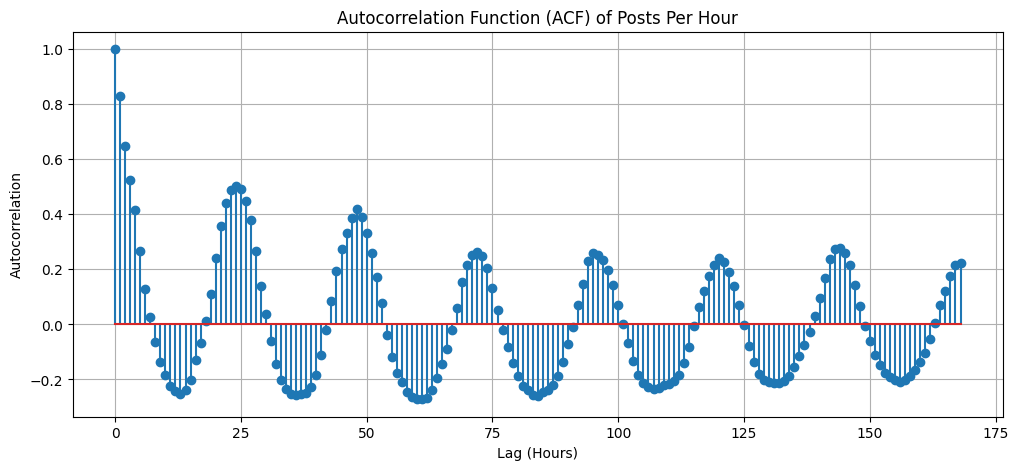

ACF plot displayed.


In [15]:
from statsmodels.tsa.stattools import acf as sm_acf
import matplotlib.pyplot as plt
import numpy as np

if 'posts_per_hour' not in locals():
    print("Error: posts_per_hour not defined. Run the aggregation cell first to create `posts_per_hour`.")
else:
    try:
        # --- Calculate and Plot ACF ---
        print("Calculating and plotting ACF...")

        # Determine a reasonable number of lags to check (e.g., a few days worth of hours)
        n_lags = 7 * 24 # Check correlations up to 7 days back

        fig, ax = plt.subplots(figsize=(12, 5)) # Create a plot figure

        # Ensure series is a 1-d numeric array / pandas Series
        series = posts_per_hour.to_pandas()['post_count'].dropna().astype(float)

        # Compute ACF values using statsmodels' acf function (robust across versions)
        acf_vals = sm_acf(series, nlags=n_lags, fft=True)
        lags = np.arange(len(acf_vals))

        ax.stem(lags, acf_vals)
        ax.set_title('Autocorrelation Function (ACF) of Posts Per Hour')
        ax.set_xlabel('Lag (Hours)')
        ax.set_ylabel('Autocorrelation')
        ax.grid(True)
        plt.show() # Display the plot
        print("ACF plot displayed.")

    except Exception as e:
        print(f"An error occurred during ACF calculation/plotting: {e}")

The ACF plot provides strong statistical confirmation of the patterns we saw in the previous visualization:

- Not White Noise: The plot shows many lags with correlation spikes far outside the blue confidence interval. This confirms the time series is not random noise and contains significant, predictable patterns.

- Strong Daily Seasonality: There are very prominent, significant positive spikes at lags 24, 48, 72, 96, 120, 144, and 168. This is a classic signature of a strong 24-hour (daily) seasonal pattern. It means the number of posts at any given hour is highly correlated with the number of posts 24 hours prior (and 48 hours prior, etc.).

- Within-Day Correlation: The lags between the daily spikes (e.g., lags 1-23) also show a pattern. The correlation starts high and positive (lag 1) and then dips, indicating that posting activity in one hour is also related to the activity in the immediately preceding and following hours.

In summary, the ACF plot confirms that the data has a strong, modelable 24-hour seasonal pattern, validating its suitability for time-series modeling.

**3. Transformation (Checking Variance)**
**Why do this?** This is the final diagnostic step for Week 1, as mentioned in your proposal. Many time-series models (and statistical tests) perform best when the variance of the data (the "spread" or "volatility") is constant over time (a property called homoscedasticity).

Our visual plot suggested that the variance might increase when the posting level increases (this is heteroscedasticity ). If this is the case, applying a mathematical transformation, such as a logarithm (log(y_t)), can help stabilize the variance, making the patterns cleaner and the model more reliable.



**How does this affect the next step?** If we find the variance is unstable, we should apply a log transformation to our post_count data. All subsequent analysis (like Burst Detection in Week 2) would then be performed on this transformed data (log(post_count)) rather than the raw counts. If the variance looks stable, we can proceed with the raw post_count data.

In [16]:
try:
    # --- Apply Log Transformation ---
    # We use log1p, which calculates log(1 + x), to avoid errors if post_count is 0
    posts_per_hour_transformed = posts_per_hour.with_columns(
        pl.col('post_count').log1p().alias('log_post_count')
    )

    print("Aggregated data with log transformation (first 5 rows):")
    print(posts_per_hour_transformed.head())

    # --- Create Comparison Plots ---

    # Plot 1: Original Data
    fig_original = px.line(posts_per_hour.to_pandas(),
                           x='post_timestamp',
                           y='post_count',
                           title='Original Posts Per Hour (Raw Count)')

    # Plot 2: Log-Transformed Data
    fig_log = px.line(posts_per_hour_transformed.to_pandas(),
                      x='post_timestamp',
                      y='log_post_count',
                      title='Log-Transformed Posts Per Hour (log(1 + Count))')

    print("Displaying plots for variance comparison...")
    fig_original.show()
    fig_log.show()
    print("Plots displayed.")

except Exception as e:
    print(f"An error occurred during transformation or plotting: {e}")

Aggregated data with log transformation (first 5 rows):
shape: (5, 3)
┌─────────────────────┬────────────┬────────────────┐
│ post_timestamp      ┆ post_count ┆ log_post_count │
│ ---                 ┆ ---        ┆ ---            │
│ datetime[μs]        ┆ u32        ┆ f64            │
╞═════════════════════╪════════════╪════════════════╡
│ 2025-01-27 05:00:00 ┆ 64         ┆ 4.174387       │
│ 2025-01-27 06:00:00 ┆ 35         ┆ 3.583519       │
│ 2025-01-27 07:00:00 ┆ 13         ┆ 2.639057       │
│ 2025-01-27 08:00:00 ┆ 20         ┆ 3.044522       │
│ 2025-01-27 09:00:00 ┆ 29         ┆ 3.401197       │
└─────────────────────┴────────────┴────────────────┘
Displaying plots for variance comparison...


Plots displayed.


**Analysis of Transformation**
- **Original Plot:** In the raw count data, the variance is unstable (heteroscedastic). The fluctuations during normal periods (e.g., Feb 5-10) are small (maybe 0-150), while the fluctuations during the major spike on Feb 13 are massive (from a low base to over 600). This difference in scale can skew the results of statistical models.


- **Log-Transformed Plot:** The log transformation has successfully stabilized the variance. The peaks and valleys now oscillate within a much more consistent range (roughly 2.5 to 6.0). The massive spike on Feb 13 is compressed and now looks proportional to the other large daily spikes (like the one on Jan 30), rather than exponentially larger.

**Decision and Next Steps**
This log-transformed data is much more suitable for the time-series modeling and statistical tests we plan to do, as it better meets the assumption of constant variance.

Therefore, for our Week 2 analysis (Burst Detection and Clustering), we will use the log_post_count column from the posts_per_hour_transformed DataFrame.

This completes all the tasks outlined for Week 1 of your proposal:

1. Setup & Data Exploration: Done.

2. Load Data: Done.

3. Perform Initial Time-Series Diagnostics:

    - Visualization: Done.

    - Autocorrelation (ACF): Done.

    - Transformation: Done.


## Week 2: Apply Burst Detection
**Why do this?** As outlined in your proposal, this is the core of "Methodology Prototyping (Burst Detection)". We're using Kleinberg's algorithm to identify anomalous "bursts" in posting activity. The pybursts library we just installed gives us a straightforward implementation of this algorithm.

**How does this affect the next step?** This analysis will produce a list of timestamps that the algorithm identifies as "bursting." This is the first major "Finding" from your data. This output will be directly used in Week 4 to create the interactive plotly visualization that highlights these specific bursts on the timeline, providing the "smoking gun" evidence your proposal mentions.

In [17]:
import numpy as np
import math
from typing import List, Tuple

# --- FIX for old library ---
# Manually re-create the deprecated 'np.float' alias
np.float = float
# ---------------------------

def kleinberg(offsets, s=2, gamma=1):

    if s <= 1:
       raise ValueError("s must be greater than 1!")
    if gamma <= 0:
       raise ValueError("gamma must be positive!")
    if len(offsets) < 1:
       raise ValueError("offsets must be non-empty!")

    offsets = np.array(offsets, dtype=object)

    if offsets.size == 1:
       bursts = np.array([0, offsets[0], offsets[0]], ndmin=2, dtype=object)
       return bursts

    offsets = np.sort(offsets)
    gaps = np.diff(offsets)

    if not np.all(gaps):
       print("Warning: Input contained events with zero time between!")
       gaps = gaps[gaps > 0] # Filter out zero gaps

    T = np.sum(gaps)
    n = np.size(gaps)
    g_hat = T / n

    k = int(math.ceil(float(1 + math.log(T, s) + math.log(1 / np.amin(gaps), s))))

    gamma_log_n = gamma * math.log(n)

    def tau(i, j):
       if i >= j:
          return 0
       else:
          return (j - i) * gamma_log_n

    alpha_function = np.vectorize(lambda x: s ** x / g_hat)
    alpha = alpha_function(np.arange(k))

    def f(j, x):
       return alpha[j] * math.exp(-alpha[j] * x)

    C = np.repeat(float("inf"), k)
    C[0] = 0

    q = np.empty((k, 0))
    for t in range(n):
       C_prime = np.repeat(float("inf"), k)
       q_prime = np.empty((k, t+1))
       q_prime.fill(np.nan)

       for j in range(k):
          cost_function = np.vectorize(lambda x: C[x] + tau(x, j))
          cost = cost_function(np.arange(0, k))

          el = np.argmin(cost)

          if f(j, gaps[t]) > 0:
             C_prime[j] = cost[el] - math.log(f(j, gaps[t]))

          if t > 0:
             q_prime[j,:t] = q[el,:]

          q_prime[j, t] = j + 1

       C = C_prime
       q = q_prime

    j = np.argmin(C)
    q = q[j,:]

    prev_q = 0

    N = 0
    for t in range(n):
       if q[t] > prev_q:
          N = N + q[t] - prev_q # N is a float
       prev_q = q[t]

    N = int(N) # <-- THIS IS THE FIX: Cast N to an integer

    bursts = np.array([np.repeat(np.nan, N), np.repeat(offsets[0],N),np.repeat(offsets[0], N)], ndmin=2, dtype=object).transpose()

    burst_counter = -1
    prev_q = 0

    stack = np.empty(N, dtype=int)

    stack_counter = -1
    for t in range(n):
       if q[t] > prev_q:
          num_levels_opened = q[t] - prev_q
          for i in range(int(num_levels_opened)):
             burst_counter += 1
             bursts[burst_counter, 0] = prev_q + i
             bursts[burst_counter, 1] = offsets[t]
             stack_counter += 1
             stack[stack_counter] = burst_counter
       elif q[t] < prev_q:
          num_levels_closed = prev_q - q[t]
          for i in range(int(num_levels_closed)):
             bursts[stack[stack_counter], 2] = offsets[t]
             stack_counter -= 1
       prev_q = q[t]

    while stack_counter >= 0:
       bursts[stack[stack_counter], 2] = offsets[n]
       stack_counter -= 1

    return bursts

In [18]:
import polars as pl
import pandas as pd
import datetime  # use datetime.timezone.utc

try:
    # --- Prepare Data for kleinberg function ---
    print("Preparing raw numeric timestamps...")
    raw_timestamps = (
        ts_df
        .sort('post_timestamp')
        .select(
            pl.col('post_timestamp').dt.epoch(time_unit="s").alias('unix_timestamp')
        )
        .unique()
        ['unix_timestamp']
        .to_list()
    )
    print(f"Prepared data for burst detection: {len(raw_timestamps)} unique timestamps.")

    # --- Run Kleinberg's Burst Detection Algorithm ---
    print("Running Kleinberg's algorithm...")
    bursts = kleinberg(raw_timestamps, s=2.0, gamma=1.0)
    print("Algorithm complete.")

    # --- Process the Results ---
    print("\n--- Detected Bursts (Level, Start, End) ---")
    print(bursts)

    posts_per_hour_with_bursts = posts_per_hour_transformed.with_columns(
        pl.lit(0).alias('burst_level')
    )

    burst_list = []

    for item in bursts:
        # Clean up data types from numpy array
        level = float(item[0])
        start_unix = int(item[1])
        end_unix = int(item[2])

        if level > 0:
            # Convert Unix int to naive UTC datetime compatible with Polars
            # Use fromtimestamp with explicit UTC and drop tzinfo to get naive UTC datetimes
            start_time = datetime.datetime.fromtimestamp(start_unix, tz=datetime.timezone.utc).replace(tzinfo=None)
            end_time = datetime.datetime.fromtimestamp(end_unix, tz=datetime.timezone.utc).replace(tzinfo=None)

            print(f"\n📈 Burst (Level {level}):")
            print(f"   From: {start_time} (Unix: {start_unix})")
            print(f"   To:   {end_time} (Unix: {end_unix})")

            burst_list.append({
                'level': level,
                'start_time': start_time, # This is now a datetime object (naive UTC)
                'end_time': end_time,     # This is now a datetime object (naive UTC)
            })

            # --- Update the AGGREGATED DataFrame for plotting ---
            cond_after_start = pl.col('post_timestamp') >= start_time
            cond_before_end = pl.col('post_timestamp') <= end_time

            posts_per_hour_with_bursts = posts_per_hour_with_bursts.with_columns(
                pl.when(cond_after_start & cond_before_end)
                  .then(pl.lit(level))
                  .otherwise(pl.col('burst_level'))
                  .alias('burst_level')
            )

    print("\n--- Summary of Bursts Found (as DataFrame) ---")
    print(pl.DataFrame(burst_list))

    print("\n--- Data with Burst Levels (for plotting) ---")
    print(posts_per_hour_with_bursts.filter(pl.col('burst_level') > 0).head())

except Exception as e:
    print(f"An error occurred during burst detection: {e}")

Preparing raw numeric timestamps...
Prepared data for burst detection: 46383 unique timestamps.
Running Kleinberg's algorithm...
Algorithm complete.

--- Detected Bursts (Level, Start, End) ---
[[0 1737954244 1739681907]
 [np.float64(1.0) 1737984904 1738002241]
 [np.float64(1.0) 1738007379 1738017507]
 [np.float64(1.0) 1738019960 1738025542]
 [np.float64(1.0) 1738034270 1738039052]
 [np.float64(1.0) 1738073650 1738074579]
 [np.float64(1.0) 1738077892 1738084719]
 [np.float64(2.0) 1738079449 1738079603]
 [np.float64(1.0) 1738109576 1738110508]
 [np.float64(1.0) 1738115421 1738115884]
 [np.float64(2.0) 1738115496 1738115865]
 [np.float64(1.0) 1738159217 1738208096]
 [np.float64(2.0) 1738164136 1738177844]
 [np.float64(2.0) 1738180422 1738182307]
 [np.float64(2.0) 1738199749 1738200863]
 [np.float64(1.0) 1738243694 1738253066]
 [np.float64(1.0) 1738257071 1738260944]
 [np.float64(1.0) 1738275145 1738277171]
 [np.float64(1.0) 1738287440 1738288184]
 [np.float64(1.0) 1738331810 1738337550]


## Visualize Burst Detection
**Why do this?** As your proposal states, this is the "smoking gun" deliverable for this part of the analysis. It translates the complex list of burst timestamps into a simple, interactive, human-readable report that allows a non-technical user to see the anomalous activity.



**How does this affect the next step?** This step creates the final output for our burst detection analysis. The posts_per_hour_with_bursts DataFrame, which we created specifically for this, has the burst_level column. We will use this column to color-code the plot, clearly highlighting the periods of anomalous activity. After this, the burst detection portion is complete, and we can move on to Week 3 with a clean slate.

In [19]:
import plotly.express as px

try:
    # --- Prepare for Plotting ---
    # We need to convert 'burst_level' to a string (categorical)
    # so Plotly treats it as distinct colors (0, 1, 2)
    # instead of a continuous number gradient.

    # Use the DataFrame we created in the last step
    plot_df = posts_per_hour_with_bursts.with_columns(
        pl.col('burst_level').cast(pl.String).alias('burst_category')
    )

    print("Creating interactive burst plot...")

    # --- Create Interactive Plot ---
    fig = px.line(
        plot_df.to_pandas(),
        x='post_timestamp',
        y='log_post_count',       # Plot the log-transformed data we analyzed
        color='burst_category',   # <-- This is the key part
        title='Burst Detection: Posts per Hour (Log Transformed)',
        labels={
            'log_post_count': 'Log(Posts per Hour)',
            'post_timestamp': 'Time',
            'burst_category': 'Burst Level'
        },
        markers=True # Add markers to make individual hours visible
    )

    fig.show() # Display the plot in the notebook
    print("Plot displayed.")

    # Optional: Save the plot as an HTML file
    # fig.write_html("burst_detection_plot.html")
    # print("\nPlot saved as burst_detection_plot.html")

except Exception as e:
    print(f"An error occurred during plotting: {e}")

Creating interactive burst plot...


Plot displayed.


In [20]:
import plotly.graph_objects as go
import polars as pl
import pandas as pd
import numpy as np

try:
    # --- Data We Need ---
    # We assume 'posts_per_hour_transformed' (a Polars DataFrame) and
    # 'burst_list' (a Python list of dicts) exist in the notebook's memory
    # from the previous cells.

    # We'll use the pandas-converted DataFrame for plotting
    plot_df = posts_per_hour_transformed.to_pandas()

    print("Creating cleaner, interactive burst plot with rectangles...")

    # --- Create the Base Figure ---
    fig = go.Figure()

    # --- 1. Add the Baseline Time Series Plot ---
    # This is the single, continuous line for the log_post_count
    fig.add_trace(
        go.Scatter(
            x=plot_df['post_timestamp'],
            y=plot_df['log_post_count'],
            mode='lines+markers',
            name='Log(Posts per Hour)',
            line=dict(color='blue'),
            marker=dict(size=4)
        )
    )

    # --- 2. Add Burst Rectangles ---

    # Define a color map for burst levels
    # We use 'rgba' to set the color and transparency (alpha)
    color_map = {
        1.0: 'rgba(255, 255, 0, 0.2)',  # Level 1: Transparent Yellow
        2.0: 'rgba(255, 165, 0, 0.3)',  # Level 2: Transparent Orange
        3.0: 'rgba(255, 0, 0, 0.4)'    # Level 3: Transparent Red
    }

    # Keep track of levels we've added to the legend
    legend_added = {1.0: False, 2.0: False, 3.0: False}

    for burst in burst_list:
        level = burst['level']
        start_time = burst['start_time']
        end_time = burst['end_time']

        # Get the color for this level
        # Default to gray if level not found
        fill_color = color_map.get(level, 'rgba(128, 128, 128, 0.2)')

        # Add a legend entry for this level, but only once
        show_legend = not legend_added.get(level, False) # Use .get for safety

        fig.add_vrect(
            x0=start_time,
            x1=end_time,
            fillcolor=fill_color,
            layer="below", # Place the rectangle behind the data line
            line_width=0,
            name=f'Burst Level {level}',
            showlegend=show_legend
        )

        # Mark this level as added to the legend
        if level in legend_added:
             legend_added[level] = True

    # --- 3. Update Layout ---
    fig.update_layout(
        title='Burst Detection: Posts per Hour (Log Transformed) with Burst Regions',
        xaxis_title='Time',
        yaxis_title='Log(Posts per Hour)',
        hovermode="x unified" # Shows a unified tooltip for all data at one x-point
    )

    fig.show()
    print("Plot displayed.")

except NameError as e:
    print(f"Error: Could not find 'posts_per_hour_transformed' or 'burst_list'.")
    print("Please make sure you have run the previous cells successfully.")
    print(f"Details: {e}")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

Creating cleaner, interactive burst plot with rectangles...


Plot displayed.


In [21]:
import plotly.express as px
import polars as pl
import pandas as pd # Plotly express Gantt chart works best with Pandas

try:
    # --- Prepare Data for Gantt Chart ---
    # We need the burst_list, but as a Pandas DataFrame for Plotly Express
    gantt_df = pd.DataFrame(burst_list)

    # We must convert burst 'level' to a string for the y-axis
    gantt_df['burst_level_str'] = gantt_df['level'].apply(lambda x: f"Level {int(x)}")

    print("Preparing Gantt chart data...")
    print(gantt_df.head())

    # --- Create the Gantt Chart ---
    fig = px.timeline(
        gantt_df,
        x_start="start_time",
        x_end="end_time",
        y="burst_level_str",     # Group bars by their burst level
        color="burst_level_str", # Color bars by their burst level
        title="Gantt Chart of Detected Burst Periods by Level",
        labels={"burst_level_str": "Burst Level"}
    )

    # Sort the Y-axis so Level 3 is at the top
    fig.update_yaxes(categoryorder='array', categoryarray=sorted(gantt_df['burst_level_str'].unique(), reverse=True))

    fig.show()
    print("Gantt chart displayed.")

except NameError as e:
    print(f"Error: Could not find 'burst_list'.")
    print("Please make sure you have run the previous burst detection cell successfully.")
    print(f"Details: {e}")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

Preparing Gantt chart data...
   level          start_time            end_time burst_level_str
0    1.0 2025-01-27 13:35:04 2025-01-27 18:24:01         Level 1
1    1.0 2025-01-27 19:49:39 2025-01-27 22:38:27         Level 1
2    1.0 2025-01-27 23:19:20 2025-01-28 00:52:22         Level 1
3    1.0 2025-01-28 03:17:50 2025-01-28 04:37:32         Level 1
4    1.0 2025-01-28 14:14:10 2025-01-28 14:29:39         Level 1


Gantt chart displayed.
